In [1]:
import os

In [2]:
# third-party library
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from models import CNN
from utils import grouper
from time import time

In [3]:
# Hyper Parameters
EPOCH = 2               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TEST_FREQ = 100
LR = 0.001              # learning rate
DOWNLOAD_MNIST = not(os.path.exists('./mnist/')) or not os.listdir('./mnist/')

In [4]:
gaussian_noise = torchvision.transforms.Lambda(lambda x : (x + torch.randn_like(x)*0.3)
                                                           .clamp(min=0, max=1))
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(0.9, 1.0)),
    torchvision.transforms.RandomRotation(degrees=10),
    torchvision.transforms.ToTensor(),
    gaussian_noise,
    torchvision.transforms.RandomErasing(scale=(0.01, 0.05))
])
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=train_transform, 
    download=DOWNLOAD_MNIST,
)
test_data = torchvision.datasets.MNIST(
    root='./mnist/', 
    train=False, 
    transform=torchvision.transforms.ToTensor()
)

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


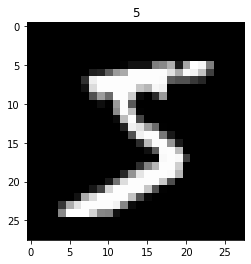

In [5]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [6]:
def train(name, timeout_sec=120, strictening=None, **kwargs):
    use_sigmoid_out = kwargs.get('use_sigmoid_out', False)
    torch.manual_seed(3582)    # reproducible    
    # Data Loader for easy mini-batch return in training, the image batch shape will be (BS, 1, 28, 28)
    train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = Data.DataLoader(dataset=test_data, batch_size=2000, shuffle=True)    
    cnn = CNN(**kwargs)
    print(cnn)  # net architecture
    optimizer = torch.optim.Adam(cnn.parameters(), amsgrad=True, lr=LR)   # okwargsize all cnn parameters
    loss_func = nn.MSELoss() if use_sigmoid_out else nn.CrossEntropyLoss()
    train_loop_with_timeout(cnn, train_loader, test_loader, optimizer, 
                            loss_func, use_sigmoid_out, strictening, timeout_sec)
    out_path = 'output/%s.pkl' % name
    torch.save(cnn, out_path)
    print('Model saved to %s' % out_path)
    return cnn
    
def train_loop_with_timeout(cnn, train_loader, test_loader, optimizer, 
                            loss_func, use_sigmoid_out, strictening, timeout_sec):
    started_sec = time()
    for epoch in range(EPOCH):
        batch_groups = grouper(train_loader, TEST_FREQ)
        for batch_group, (test_x, test_y) in zip(batch_groups, test_loader): 
            for train_x, train_y in batch_group:
                output, _ = cnn(train_x)
                if use_sigmoid_out:
                    train_y = one_hot(train_y, num_classes=10).float()
                    loss = loss_func(output, train_y)
                else:
                    loss = loss_func(output, train_y)
                if strictening is not None and strictening > 0:
                    modules = [cnn.conv1[0], cnn.conv2[0], cnn.out[0]]
                    weight_reg = sum(m.weight.abs().mean() for m in modules)
                    bias_reg = sum(m.bias.mean() for m in modules) # notice: no abs()
                    loss += strictening * (weight_reg + bias_reg)
                optimizer.zero_grad()           # clear gradients for this training step
                loss.backward()                 # backpropagation, compute gradients
                optimizer.step()                # apply gradients

            test_output, _ = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            
            elapsed_sec = time() - started_sec
            if elapsed_sec > timeout_sec:
                print('Timeout (%.2f sec), training is terminated' % elapsed_sec)
                return

In [7]:
%%time
_ = train('cnn-mnist-relu', use_relog=False, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.6561 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3835 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1844 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1075 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1885 | test accuracy: 0.97
Epoch:  1 | train loss: 0.2757 | test accuracy: 0.97
Epoch:  1 | train loss: 0.2248 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1498 | test accuracy: 0.98
Epoch:  1 | train loss: 0.1781 | test accuracy: 0.98
Epoch:  1 | train loss: 0.

In [16]:
%%time
_ = train('cnn-mnist-relu-strictening_0.01', use_relog=False, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32, strictening=0.01)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.3527 | test accuracy: 0.92
Epoch:  0 | train loss: -0.1152 | test accuracy: 0.94
Epoch:  0 | train loss: -0.6351 | test accuracy: 0.97
Epoch:  0 | train loss: -0.8585 | test accuracy: 0.96
Epoch:  0 | train loss: -1.1358 | test accuracy: 0.97
Epoch:  1 | train loss: -1.2598 | test accuracy: 0.97
Epoch:  1 | train loss: -1.7414 | test accuracy: 0.98
Epoch:  1 | train loss: -1.9860 | test accuracy: 0.97
Epoch:  1 | train loss: -2.2139 | test accuracy: 0.98
Epoch:  1 | train 

In [17]:
%%time
_ = train('cnn-mnist-relu-strictening_0.1', use_relog=False, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32, strictening=0.1)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.2523 | test accuracy: 0.92
Epoch:  0 | train loss: -0.1632 | test accuracy: 0.95
Epoch:  0 | train loss: -0.6006 | test accuracy: 0.96
Epoch:  0 | train loss: -0.8396 | test accuracy: 0.96
Epoch:  0 | train loss: -1.1419 | test accuracy: 0.96
Epoch:  1 | train loss: -1.3535 | test accuracy: 0.97
Epoch:  1 | train loss: -1.7100 | test accuracy: 0.97
Epoch:  1 | train loss: -1.9951 | test accuracy: 0.97
Epoch:  1 | train loss: -2.2644 | test accuracy: 0.97
Epoch:  1 | train 

In [20]:
%%time
_ = train('cnn-mnist-relu-strictening_5', use_relog=False, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32, strictening=5)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: -0.5855 | test accuracy: 0.91
Epoch:  0 | train loss: -2.3500 | test accuracy: 0.93
Epoch:  0 | train loss: -3.9929 | test accuracy: 0.95
Epoch:  0 | train loss: -5.4988 | test accuracy: 0.95
Epoch:  0 | train loss: -7.0087 | test accuracy: 0.96
Epoch:  1 | train loss: -8.4874 | test accuracy: 0.96
Epoch:  1 | train loss: -10.0799 | test accuracy: 0.97
Epoch:  1 | train loss: -11.5099 | test accuracy: 0.95
Epoch:  1 | train loss: -13.0681 | test accuracy: 0.97
Epoch:  1 | tr

In [7]:
%%time
_ = train('cnn-mnist-relog', use_relog=True, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLog()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLog()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.8526 | test accuracy: 0.86
Epoch:  0 | train loss: 0.5189 | test accuracy: 0.90
Epoch:  0 | train loss: 0.4425 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3145 | test accuracy: 0.94
Epoch:  0 | train loss: 0.3025 | test accuracy: 0.95
Epoch:  1 | train loss: 0.3456 | test accuracy: 0.95
Epoch:  1 | train loss: 0.2387 | test accuracy: 0.95
Epoch:  1 | train loss: 0.2593 | test accuracy: 0.96
Epoch:  1 | train loss: 0.2044 | test accuracy: 0.97
Timeout (133.03 sec), tr

In [8]:
%%time
_ = train('cnn-mnist-relog-more-neurons', use_relog=True, use_maxout=False,
          conv1_out_channels=64, conv2_out_channels=128)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLog()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLog()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=6272, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.9368 | test accuracy: 0.76
Epoch:  0 | train loss: 0.8526 | test accuracy: 0.86
Timeout (155.40 sec), training is terminated
Model saved to output/cnn-mnist-relog-more-neurons.pkl
CPU times: user 2min 18s, sys: 13.4 s, total: 2min 32s
Wall time: 2min 35s


In [9]:
%%time
_ = train('cnn-mnist-relog-maxout', use_relog=True, use_maxout='max',
          conv1_out_channels=16, conv2_out_channels=32, max_folding_factor=4)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLog()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLog()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=40, bias=True)
    (1): FoldingMaxout(use_min=False, k=4)
  )
)
Epoch:  0 | train loss: 2.1063 | test accuracy: 0.44
Epoch:  0 | train loss: 0.8377 | test accuracy: 0.83
Timeout (130.45 sec), training is terminated
Model saved to output/cnn-mnist-relog-maxout.pkl
CPU times: user 2min 18s, sys: 11.7 s, total: 2min 30s
Wall time: 2min 10s


In [7]:
%%time
_ = train('cnn-mnist-relog-maxout-sigmoid-out', use_relog=True, 
          conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='max', max_folding_factor=4, use_sigmoid_out=True,
          timeout_sec=900)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLog()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLog()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=40, bias=True)
    (1): FoldingMaxout(use_min=False, k=4)
    (2): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.0759 | test accuracy: 0.57
Epoch:  0 | train loss: 0.0339 | test accuracy: 0.87
Epoch:  0 | train loss: 0.0266 | test accuracy: 0.91
Epoch:  0 | train loss: 0.0200 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0145 | test accuracy: 0.94
Epoch:  1 | train loss: 0.0114 | test accuracy: 0.95
Epoch:  1 | train loss: 0.0151 | t

In [8]:
%%time
_ = train('cnn-mnist-relog-minmaxout_4_2-sigmoid-out', use_relog=True, 
          conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='minmax', min_folding_factor=4, max_folding_factor=2, 
          use_sigmoid_out=True, timeout_sec=1200)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=2)
    (2): FoldingMaxout(use_min=False, k=4)
    (3): ReLog()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=2)
    (2): FoldingMaxout(use_min=False, k=4)
    (3): ReLog()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=80, bias=True)
    (1): FoldingMaxout(use_min=True, k=2)
    (2): FoldingMaxout(use_min=False, k=4)
    (3): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.0542 | test accuracy: 0.71
Epoch:  0 | train loss: 0.0281 | test accuracy: 0.88
Epoch:  0 | train loss: 0.0223 | test accuracy: 0.92
Epoch:  0 | train loss: 0.0172 | test accuracy: 0.95
Epoch:  0 | t

In [8]:
%%time
_ = train('cnn-mnist-relog-minmaxout_4_2-sigmoid-out-strictening_1', use_relog=True, 
          conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='minmax', min_folding_factor=4, max_folding_factor=2,
          use_sigmoid_out=True, strictening=1, timeout_sec=1200)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=80, bias=True)
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): Sigmoid()
  )
)
Epoch:  0 | train loss: -0.1290 | test accuracy: 0.37
Epoch:  0 | train loss: -0.4764 | test accuracy: 0.61
Epoch:  0 | train loss: -0.7870 | test accuracy: 0.73
Epoch:  0 | train loss: -1.0865 | test accuracy: 0.79
Epoch:  0

**Unused snipets**

In [12]:
# # following function (plot_with_labels) is for visualization, can be ignored if not interested
# from matplotlib import cm
# try: from sklearn.manifold import TSNE; HAS_SK = True
# except: HAS_SK = False; print('Please install sklearn for layer visualization')
# def plot_with_labels(lowDWeights, labels):
#     plt.cla()
#     X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
#     for x, y, s in zip(X, Y, labels):
#         c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
#     plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

# plt.ion()

# ...
#             if HAS_SK:
#                 # Visualization of trained flatten layer (T-SNE)
#                 tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
#                 plot_only = 500
#                 low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
#                 labels = test_y.numpy()[:plot_only]
#                 plot_with_labels(low_dim_embs, labels)
# plt.ioff()

In [13]:
# # print 10 predictions from test data
# test_output, _ = cnn(test_x[:10])
# pred_y = torch.max(test_output, 1)[1].data.numpy()
# print(pred_y, 'prediction number')
# print(test_y[:10].numpy(), 'real number')